In [ ]:
# фиксируем более-менее актуальные версии для воспроизводимости
# api некоторых пакетов может меняться
!pip install -U nltk==3.8.1
!pip install -U gensim==4.3.2
!pip install -U torchtext==0.17.0
!pip install -U spacy==3.6.0
!pip install -U portalocker==2.8.2
# скачаем для использования spacy-токенайзера
!python -m spacy download en_core_web_sm

In [ ]:
import numpy as np
import random
import time

from tqdm import tqdm
from IPython.display import clear_output
from matplotlib import pyplot as plt

import gensim
import nltk

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

from collections import Counter, OrderedDict
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext import data, datasets
from torchtext.data.functional import to_map_style_dataset

nltk.download("punkt") # для токенизации текстов и работы с пунктуацией
nltk.download("wordnet") # для графа зависимостей между словами

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Зафиксируем random seed для воспроизводимости результатов

In [ ]:
SEED = 1234
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Скачаем данные, представив их в виде трейна, валидации и теста.

In [ ]:
train_iter, test_iter = datasets.IMDB()

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# размер. обуч выборки
num_train = int(len(train_dataset) * 0.9)

train_data, valid_data = random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train],
    torch.Generator().manual_seed(SEED)
)

In [ ]:
def binary_accuracy(preds, y):
    """
    Возвращает точность модели.

    Параметры.
    1) preds — предсказания модели,
    2) y — истинные метки классов.
    """

    # округляет предсказания до ближайшего integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion, loss_history):
    """
    Функция для обучения модели на обучающем датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор обучающего датасета,
    3) optimizer — класс метода оптимизации,
    4) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch_id, batch in enumerate(iterator):
        # чтобы градиент не накапливался, его нужно обнулить
        optimizer.zero_grad()
        # получим предсказания модели
        texts, labels = batch
        predictions = model(texts).squeeze(1)
        loss = criterion(predictions, labels)
        acc = binary_accuracy(predictions, labels)

        # сделаем back-propagation для подсчёта градиентов
        loss.backward()
        # выполним шаг оптимизатора
        optimizer.step()
        # обновим метрики
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, loss_history=None):
    """
    Функция для применения модели на валидационном/тестовом датасете и подсчёта
    её точности.

    Параметры.
    1) model — модель,
    2) iterator — итератор датасета,
    3) criterion — функция потерь.
    """

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad(): # отключим подсчёт градиентов на валидации
        for batch_id, batch in enumerate(iterator):
            inp, label = batch

            # получим предсказания
            predictions = model(inp).squeeze(1)
            # посчитаем метрики
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)
            # обновим метрики
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            if loss_history is not None:
                loss_history.append(loss.item())

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    """
    Функция для подсчёта времени работы одной эпохи.

    Параметры.
    1) start_time — время начала запуска,
    2) end_time — время завершения работы эпохи.
    """

    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def training_loop(model_instance, n_epochs=10):
    """
    Функция для обучения нейронной сети.

    Параметры.
    1) model_instance — обучаемая модель,
    2) n_epochs — количество эпох.
    """

    best_valid_loss = float('inf')
    loss_history = []
    val_loss_history = []
    acc_history = []
    val_acc_history = []

    for epoch in range(n_epochs):
        start_time = time.time()
        # Обучим одну эпоху на обучающем датасете
        train_loss, train_acc = train(model_instance, train_loader, optimizer, criterion, loss_history)
        acc_history.append(train_acc)

        # Оценим точность модели на тестовом датасете
        valid_loss, valid_acc = evaluate(model_instance, valid_loader, criterion, val_loss_history)
        val_acc_history.append(valid_acc)

        # Посчитаем время работы одной эпохи
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        # Отобразим графики loss'ов
        clear_output(True)
        plt.figure(figsize=(18, 6))
        plt.subplot(1, 3, 1)
        plt.plot(loss_history)
        plt.title("Train Loss")
        plt.xlabel("Номер батча")
        plt.subplot(1, 3, 2)
        plt.plot(val_loss_history, color="tab:orange")
        plt.title("Valid Loss")
        plt.xlabel("Номер батча")
        # Если значение функции потерь улучшилось, сохраним параметры модели
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_instance.state_dict(), "model_checkpoint.pt")

        # Отрисуем значение точности от эпохи
        plt.subplot(1, 3, 3)
        plt.plot(acc_history, label="Train")
        plt.plot(val_acc_history, label="Valid")
        plt.legend()
        plt.title("Accuracy")
        plt.xlabel("Номер эпохи")
        plt.show()

        print(f"Номер эпохи: {epoch+1:02} | Время обучения эпохи: {epoch_mins}m {epoch_secs}s")

__1. Предобработка данных__

In [ ]:
train_text_list = [word_tokenize(text) for _, text in train_data]
train_label_list = [label for label, _ in train_data]

valid_text_list = [word_tokenize(text) for _, text in valid_data]
valid_label_list = [label for label, _ in valid_data]

test_text_list = [word_tokenize(text) for _, text in test_dataset]
test_label_list = [label for label, _ in test_dataset]

Применим стемминг.

In [ ]:
stemmer = PorterStemmer()

def stem_words(data):
    return [[stemmer.stem(word.lower()) for word in sentence] for sentence in data]

train_text_list = stem_words(train_text_list)
valid_text_list = stem_words(valid_text_list)
test_text_list = stem_words(test_text_list)

Ограничим словарь для модели, убрав наименее частые слова. Это сделает обучение модели менее ресурсозатратным, а также позволит избавиться от потенциальных слов с орфографическими ошибками.

Обратим внимание, что формировать словарь мы начинаем после того, как применили стемминг. В противном случае из-за несовпадения токенов в словаре и текстах мы имели бы дело с большим кол-вом UNK-токенов.

In [ ]:
MAX_VOCAB_SIZE = 25000
counter = Counter()

for sentence in train_text_list:
    counter.update(
        token for token in sentence
    )
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))
vocab = torchtext.vocab.vocab(ordered_dict)

In [ ]:
unk_token = '<unk>'
vocab.append_token(unk_token)
# используем по-умолчанию для токенов вне словаря
vocab.set_default_index(vocab[unk_token])
UNK_IDX = vocab[unk_token]

Создайте итератор для обучающего, валидационного и тестового датасетов. Будет полезно обратить внимание на типы датасетов в Pytorch: [ссылка](https://pytorch.org/docs/stable/data.html#dataset-types).

In [ ]:
BATCH_SIZE = 64

def pad_collate(batch):
    """
    Формирует тензоры из токенизированных текстов и меток, а также
    дополняет последовательности токенов до макс. длины в батче с UNK_IDX
    """
    texts, labels = zip(*batch)

    # сформируем тензоры
    texts_tensors = [torch.LongTensor(t).to(DEVICE) for t in texts]
    labels_tensors = torch.FloatTensor(labels).to(DEVICE)
    # дополним до макс. длины в батче
    texts_padded = pad_sequence(
        texts_tensors,
        batch_first=True,
        padding_value=UNK_IDX
    )
    return texts_padded, labels_tensors

In [ ]:
train_texts = [vocab(text) for text in train_text_list]
valid_texts = [vocab(text) for text in valid_text_list]
test_texts = [vocab(text) for text in test_text_list]

In [ ]:
# кодируем в 0 и 1 целевые метки
le = LabelEncoder()

train_labels = le.fit_transform([label for label, _ in train_data])
valid_labels = le.transform([label for label, _ in valid_data])
test_labels = le.transform([label for label, _ in test_dataset])

In [ ]:
train_loader = DataLoader(
    list(zip(train_texts, train_labels)),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=pad_collate
)

valid_loader = DataLoader(
    list(zip(valid_texts, valid_labels)),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=pad_collate
)

test_loader = DataLoader(
    list(zip(test_texts, test_labels)),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=pad_collate
)

Зададим модель, аналогичную той, что была на семинаре.

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):
        """
        Функция инициализации модели.

        Параметры.
        1) vocab_size — размер словаря,
        2) embedding_dim — размерность векторов-эмбеддингов,
        3) n_filters — количество свёрточных фильтров на каждом слое,
        4) filter_sizes — количество свёрточных слоёв,
        5) output_dim — размер выхода модели,
        6) dropout — вещественное число от 0 до 1, вероятность отключения нейронов,
        7) pad_idx — токен для паддинга.
        """

        super().__init__()
        # эмбеддинг-слой
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        # свёрточные слои
        self.convs = nn.ModuleList([
          nn.Conv1d(
              in_channels=embedding_dim, out_channels=n_filters,
              kernel_size=fs,
          ) for fs in filter_sizes
        ])
        # полносвязный слой для получение выхода модели
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        # dropout для регуляризации сети
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        """ Функция для получения выходов сети по текстам """

        #text.dim = [batch size, sent len]
        #embedded.dim = [batch size, sent len, emb dim]
        embedded = self.embedding(text)

        #embedded.dim = [batch size, emb dim, sent len]
        embedded = embedded.permute(0, 2, 1)

        #conved_n.dim = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        conved = [F.relu(conv(embedded)) for conv in self.convs]

        #pooled_n.dim = [batch size, n_filters]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        #cat.dim = [batch size, n_filters * len(filter_sizes)]
        cat = self.dropout(torch.cat(pooled, dim = 1))

        return self.fc(cat)

Проинициализируем и обучим модель.

In [ ]:
INPUT_DIM = len(vocab)  # размер словаря
EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [3,4,5]  # размеры фильтров на каждом уровне
OUTPUT_DIM = 1  # размерность выхода (сеть выдаёт вероятность для одного класса)
DROPOUT = 0.5  # вероятность dropout
PAD_IDX = UNK_IDX  # id токена для паддинга
# если есть возможность подключиться к GPU, сделаем это
# для ускорения вычислений
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(DEVICE)

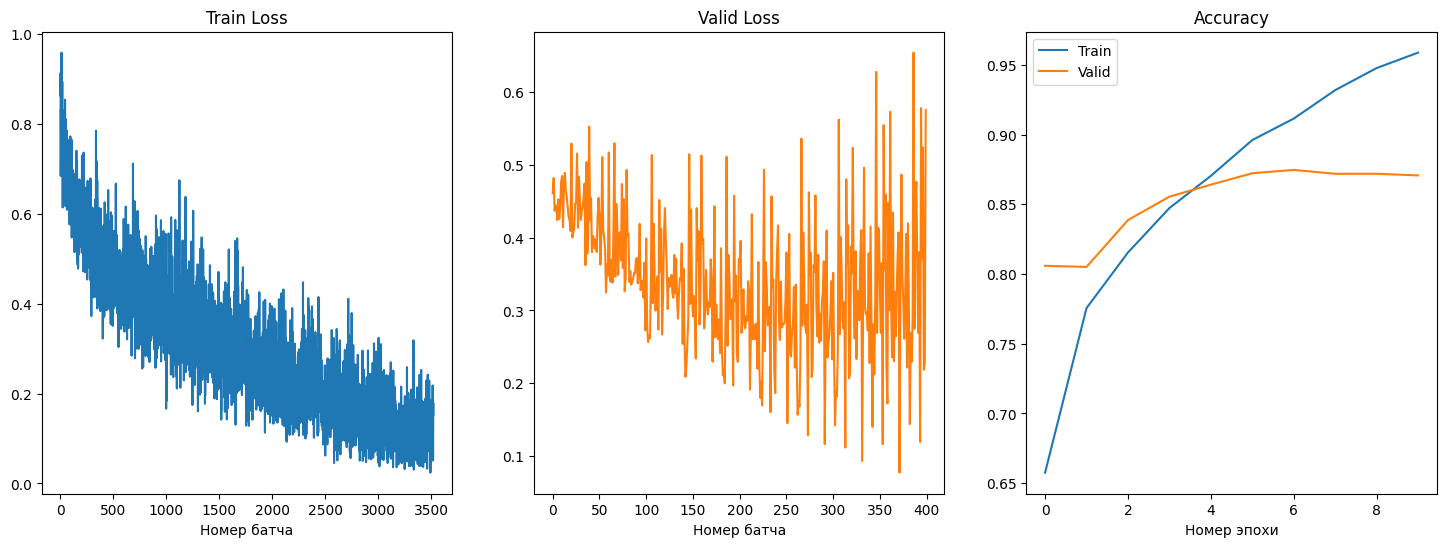

Номер эпохи: 10 | Время обучения эпохи: 0m 12s


In [ ]:
training_loop(model)

Посчитаем качество модели на тестовой выборке.

In [ ]:
model.load_state_dict(torch.load("model_checkpoint.pt"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.277 | Test Acc: 88.17%


__2. Изменение размера эмбеддинга__

Уменьшите размер эмбеддингов до 30.

Повторим предыдущий код для обработки данных.

In [ ]:
train_iter, test_iter = datasets.IMDB()

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# размер. обуч выборки
num_train = int(len(train_dataset) * 0.9)

train_data, valid_data = random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train],
    torch.Generator().manual_seed(SEED)
)

In [ ]:
train_text_list = [word_tokenize(text) for _, text in train_data]
train_label_list = [label for label, _ in train_data]

valid_text_list = [word_tokenize(text) for _, text in valid_data]
valid_label_list = [label for label, _ in valid_data]

test_text_list = [word_tokenize(text) for _, text in test_dataset]
test_label_list = [label for label, _ in test_dataset]

In [ ]:
MAX_VOCAB_SIZE = 25000
counter = Counter()

for sentence in train_text_list:
    counter.update(
        token for token in sentence
    )
ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))
vocab = torchtext.vocab.vocab(ordered_dict)

In [ ]:
unk_token = '<unk>'
vocab.append_token(unk_token)
# используем по-умолчанию для токенов вне словаря
vocab.set_default_index(vocab[unk_token])
UNK_IDX = vocab[unk_token]

In [ ]:
train_texts = [vocab(text) for text in train_text_list]
valid_texts = [vocab(text) for text in valid_text_list]
test_texts = [vocab(text) for text in test_text_list]

In [ ]:
# кодируем в 0 и 1 целевые метки
le = LabelEncoder()

train_labels = le.fit_transform([label for label, _ in train_data])
valid_labels = le.transform([label for label, _ in valid_data])
test_labels = le.transform([label for label, _ in test_dataset])

In [ ]:
train_loader = DataLoader(
    list(zip(train_texts, train_labels)),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=pad_collate
)

valid_loader = DataLoader(
    list(zip(valid_texts, valid_labels)),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=pad_collate
)

test_loader = DataLoader(
    list(zip(test_texts, test_labels)),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=pad_collate
)

Зададим целевой размер эмбеддинга.

In [ ]:
EMBEDDING_DIM = 30

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(DEVICE)

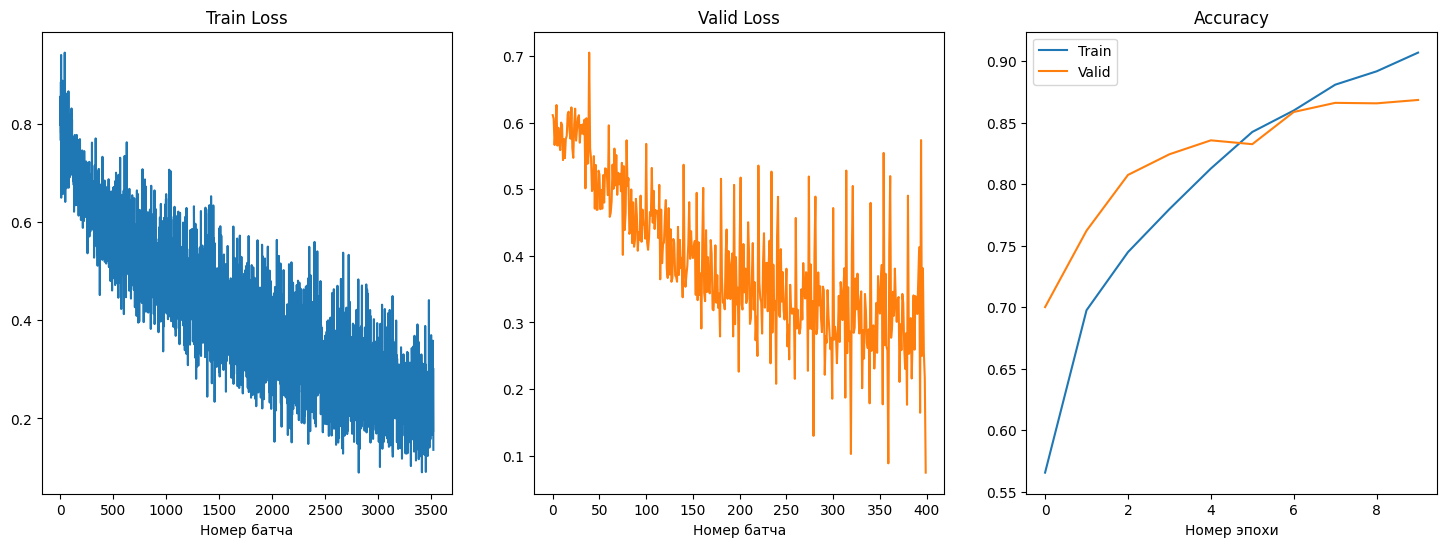

Номер эпохи: 10 | Время обучения эпохи: 0m 7s


In [ ]:
training_loop(model)

In [ ]:
model.load_state_dict(torch.load("model_checkpoint.pt"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.302 | Test Acc: 87.34%


Теперь  увеличьте размер эмбеддингов до 200.

In [ ]:
EMBEDDING_DIM = 200

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(DEVICE)

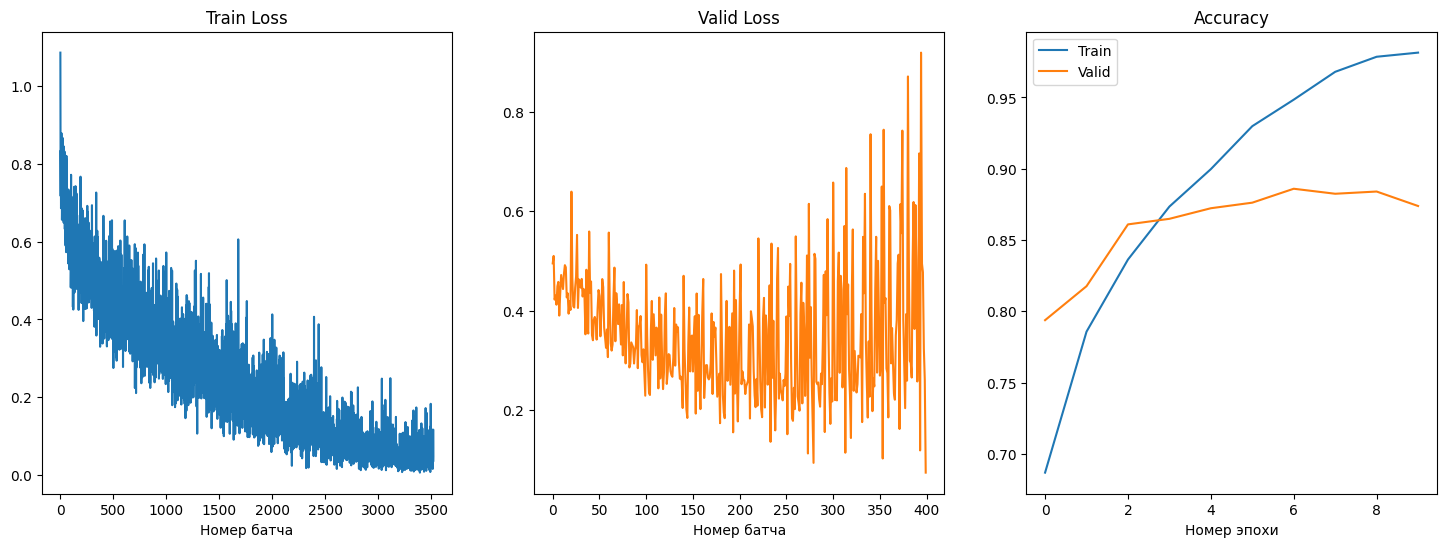

Номер эпохи: 10 | Время обучения эпохи: 0m 18s


In [ ]:
training_loop(model)

In [ ]:
model.load_state_dict(torch.load("model_checkpoint.pt"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.279 | Test Acc: 88.32%


Использование большой размерности эмбеддинга позволило получить чуть большую точность. Стоит также отметить, что на графике кривых обучения для модели с размерностью эмбеддинга 200 явно виден рост лосса на валидации, что скорее всего свидетельствует о небольшом переобучении. Понятно, что это связано с слишком большим кол-вом параметров.

__3. Нахождение близких слов по эмбеддингам.__

Напишем функцию, считающую [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) между двумя векторами. Именно косинусная мера близости очень часто используется в качестве меры схожести двух эмбеддинг-векторов.

In [ ]:
def cosine_similarity(a, b):
    denominator = np.sum(a * a) * np.sum(b * b)
    if denominator == 0:
        return 0
    return np.sum(a * b) / np.sqrt(denominator)

Напишем функцию, которая принимает на вход слово word и $k$ и возвращает $k$ наиболее похожих на word слов.

Эмбеддинги для каждого слова должны быть получены с помощью матрицы эмбеддингов из Embedding слоя вашей модели. В качестве модели возьмите модель из предыдущего пункта с маленьким размером эмбеддинга.

Чтобы по слову получить его индекс в словаре и обратно можно воспользоваться методами: `lookup_indices` и `lookup_token`. Подробнее про эти методы можно посмотреть в [документации](https://pytorch.org/text/stable/vocab.html) используемеого `torchtext`'a.



In [ ]:
embeddings = model.embedding.weight.data.cpu().numpy()

def find_most_similar(word, k):
    """ Поиск ближайших k слов к слову word по cosine similarity. """
    word_ind = vocab([word.lower()])
    word_emb = embeddings[word_ind]

    similarities = np.array([cosine_similarity(word_emb, embeddings[i]) for i in range(len(vocab))])
    topk_sims = np.argpartition(-similarities, k)[:k]
    topk_sims = np.argsort(similarities)[-k:]
    most_sim_words = vocab.lookup_tokens(topk_sims)
    return most_sim_words

Выберем несколько слов из словаря и посмотрите на их ближайшие по эмбеддингу 5 слов.

In [ ]:
find_most_similar('great', 5)

['Meyers', 'BEST', 'everyday', 'compete', 'great']

In [ ]:
find_most_similar('drama', 5)

['handles', 'Tomorrow', 'one-liners', 'Stubby', 'drama']

In [ ]:
find_most_similar('wife', 5)

['supplies', 'shallow', 'forcefully', 'store', 'wife']

__4. Эксперементы со свёртками.__

Обучите модель с фильтрами меньших размеров: 1, 2 и 3.

In [ ]:
EMBEDDING_DIM = 100  # размерность векторов-эмбеддингов
N_FILTERS = 100  # количество свёрточных фильтров
FILTER_SIZES = [1,2,3]  # размеры фильтров на каждом уровне

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

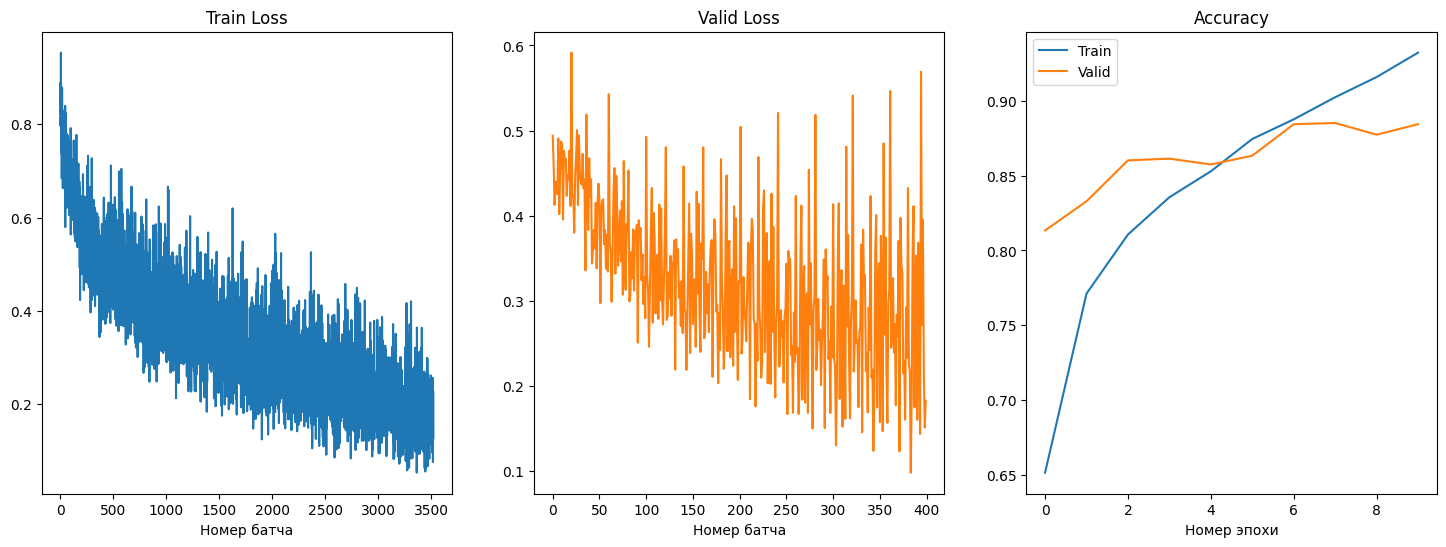

Номер эпохи: 10 | Время обучения эпохи: 0m 10s


In [ ]:
training_loop(model)

In [ ]:
model.load_state_dict(torch.load("model_checkpoint.pt"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.271 | Test Acc: 88.87%


Теперь рассмотрим лишь фильтры размера 1 и 2.

In [ ]:
FILTER_SIZES = [1, 2]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

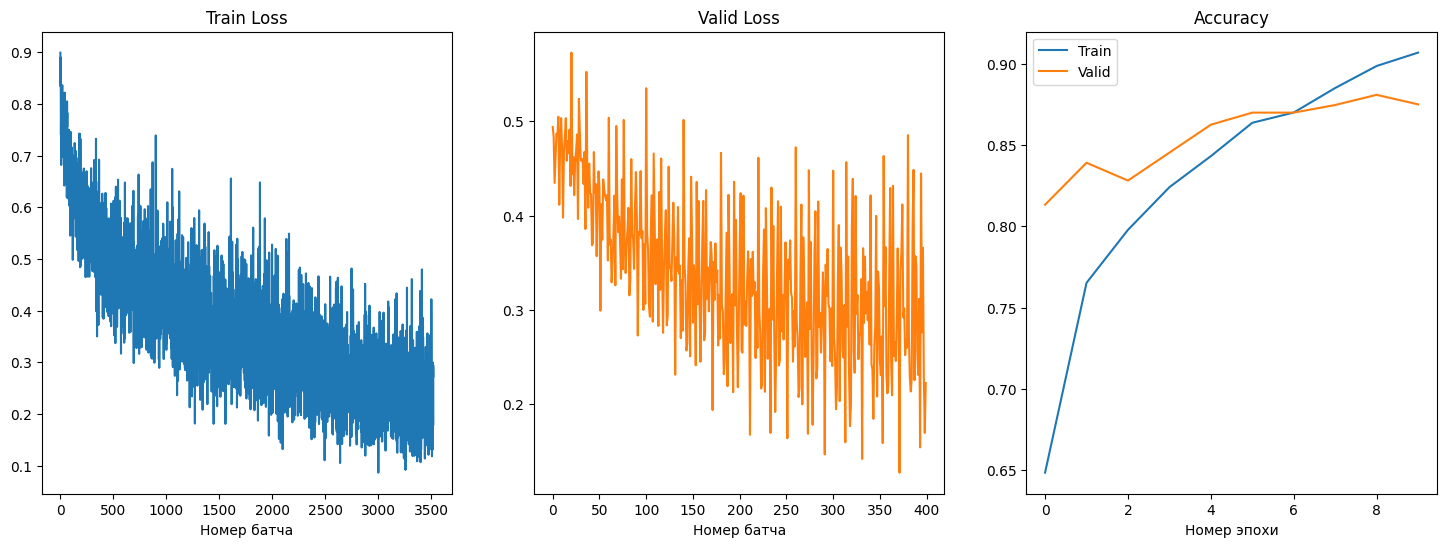

Номер эпохи: 10 | Время обучения эпохи: 0m 7s


In [ ]:
training_loop(model)

In [ ]:
model.load_state_dict(torch.load("model_checkpoint.pt"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.284 | Test Acc: 88.08%


Качество поменялось не очень сильно. Скорее всего это связано с простотой решаемой задачи. Для более наглядного сравнения для разных сверток стоило изобразить **графики точности на одном полотне**. Так сравнивать две модели было бы удобнее, а график был бы более информативным.

__5. Аугментация данных.__

Попробуем сделать аугментацию текста.

Замените слово на синоним с некоторой вероятностью $p$. То есть с вероятностью $p$ каждое слово будет заменено на некоторый его синоним, а с вероятностью $1 - p$ слово останется как есть.


In [ ]:
def word_to_synonym(word):
    """ Возвращает по слову word его синоним. """
    if not len(wordnet.synsets(word)):
        return word

    synset_id = np.random.choice(len(wordnet.synsets(word)))
    return np.random.choice(wordnet.synsets(word)[synset_id].lemma_names())

def augment_words(data):
    """ Реализует предложенную стратегию аугментации текста. """
    return [
        list(np.concatenate([word_to_synonym(word.lower()).split('_')
        if random.random() < 0.15 else [word]
        for word in sentence]))
        for sentence in data
    ]

Посмотрим на пример работы.

In [ ]:
word_to_synonym("computer")

'reckoner'

Снова проделаем стандартную предобработку.

In [ ]:
train_iter, test_iter = datasets.IMDB()

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# размер. обуч выборки
num_train = int(len(train_dataset) * 0.9)

train_data, valid_data = random_split(
    train_dataset,
    [num_train, len(train_dataset) - num_train],
    torch.Generator().manual_seed(SEED)
)

In [ ]:
train_text_list = [word_tokenize(text) for _, text in train_data]
train_label_list = [label for label, _ in train_data]

valid_text_list = [word_tokenize(text) for _, text in valid_data]
valid_label_list = [label for label, _ in valid_data]

test_text_list = [word_tokenize(text) for _, text in test_dataset]
test_label_list = [label for label, _ in test_dataset]

Для обучающего датасета сделаем аугментацию.

In [ ]:
train_text_list = augment_words(train_text_list)

Снова повторим уже знакомый кусок кода. В решении домашнего задания такую типичную подготовку данных стоило вынести с отдельную функцию.

In [ ]:
MAX_VOCAB_SIZE = 25000
counter = Counter()

for sentence in train_text_list:
    counter.update(
        token for token in sentence
    )

ordered_dict = OrderedDict(counter.most_common(MAX_VOCAB_SIZE))
vocab = torchtext.vocab.vocab(ordered_dict)

In [ ]:
unk_token = '<unk>'
vocab.append_token(unk_token)
# используем по-умолчанию для токенов вне словаря
vocab.set_default_index(vocab[unk_token])
UNK_IDX = vocab[unk_token]

In [ ]:
train_texts = [vocab(text) for text in train_text_list]
valid_texts = [vocab(text) for text in valid_text_list]
test_texts = [vocab(text) for text in test_text_list]

In [ ]:
# кодируем в 0 и 1 целевые метки
le = LabelEncoder()

train_labels = le.fit_transform([label for label, _ in train_data])
valid_labels = le.transform([label for label, _ in valid_data])
test_labels = le.transform([label for label, _ in test_dataset])

In [ ]:
train_loader = DataLoader(
    list(zip(train_texts, train_labels)),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=pad_collate
)

valid_loader = DataLoader(
    list(zip(valid_texts, valid_labels)),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=pad_collate
)

test_loader = DataLoader(
    list(zip(test_texts, test_labels)),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=pad_collate
)

In [ ]:
EMBEDDING_DIM = 100

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(DEVICE)

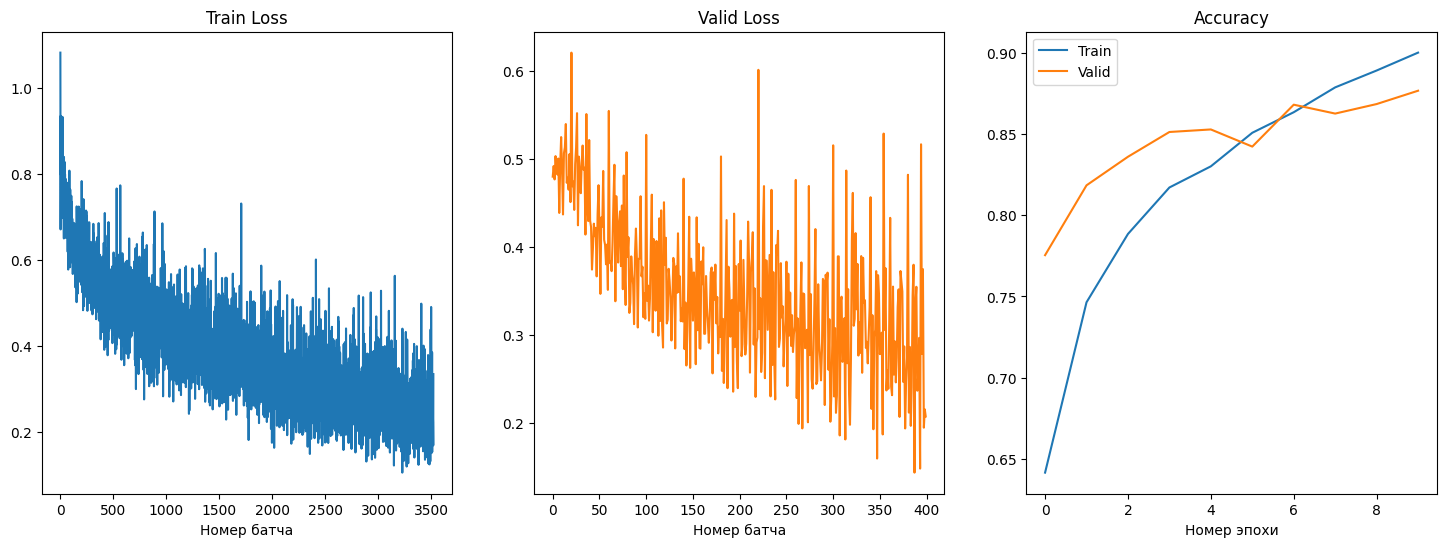

Номер эпохи: 10 | Время обучения эпохи: 0m 8s


In [ ]:
training_loop(model)

In [ ]:
model.load_state_dict(torch.load("model_checkpoint.pt"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.280 | Test Acc: 87.99%


Точность на тестовой выборке значимо не повысилась.